We start by creating the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

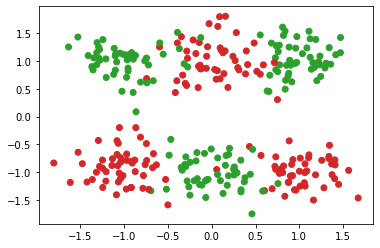

In [12]:
# N - number of datapoints per origin
N = 50
# S = scale factor in randn
S = 0.3

origins = {(1,1) : 0, (0,1) : 1, (-1,1) : 0,
           (1,-1) : 1, (0,-1) : 0, (-1,-1) : 1}
colors = {0 : '#2ca02c', 1 : '#d62728'}

X = list()
Y = list()
k=0
for (x,y) in origins:
    r = np.random.normal(loc = 0, scale = S, size = (N,2))
    l = [(x+rx, y+ry) for (rx,ry) in r]
    X +=l
    Y += [origins[(x,y)]] * N
X = np.array(X)
Y = np.array(Y)
C = [colors[y] for y in Y]
plt.scatter(X[:,0], X[:,1], c=C)
Y = Y.reshape(-1,1)

In [13]:
# we prepare summary plot
# we assume pred([points], weights) returns predictions of currently tested model
import pylab

def summ():
    xr = np.arange(-2,2,0.04)
    yr = np.arange(-2,2,0.04)
    data = list()
    for x in xr:
        for y in yr:
            data.append((x,y))
    data = np.array(data)
    Z = np.array(pred(data, w))
    Z = np.reshape(Z, (100,100))
    
    im = pylab.imshow(Z,cmap=pylab.cm.RdBu)
    cset = pylab.contour(Z,np.arange(-1,1,0.3),linewidths=2,cmap=pylab.cm.Set2)
    pylab.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    pylab.colorbar(im)

Now lets train some models

Let's try first to classify the points using logistic regression

In [14]:
# we define a function to produce features 
# for fitting polynomial of given degree to the data
def getPolyFeatures(X, degree : int):
    if(degree == 0):
        return np.ones((1, len(X))).T;
    features = list()
    for (x,y) in X:
        features.append([(x**i)*(y**(degree-i)) for i in range(degree+1)])
    A = np.array(features)
    return np.hstack([getPolyFeatures(X, degree-1), A])

In [15]:
# test of written function
print(getPolyFeatures([(2,3),(1,2)], 3))

[[ 1.  3.  2.  9.  6.  4. 27. 18. 12.  8.]
 [ 1.  2.  1.  4.  2.  1.  8.  4.  2.  1.]]


In [16]:
def sig(z):
    # in case of overflow
    if(z<-10):
        return 0
    return 1/(1+np.exp(-z))
def h(w,x):
    return sig(np.dot(w,x))
def grad(w,x,y):
    return (h(w,x)-y)*x
def gradSum(w,X,Y):
    assert len(X) == len(Y)
    return np.add.reduce([grad(w,x,y) for (x,y) in zip(X,Y)])/len(X)
def loss(w,x,y):
    return -(y*np.log(h(w,x))+(1-y)*np.log(1-h(w,x)))
def lossSum(w,X,Y):
    assert len(X) == len(Y)
    return np.add.reduce([loss(w,x,y) for (x,y) in zip(X,Y)])/len(X)
def SGD(lr, epochs, X, Y):
    w=np.zeros(X.shape[1])
    data = np.hstack([X,Y])
    rng = np.random.default_rng()
    for n in range(epochs):
        rng.shuffle(data)
        for d in data:
            w=w-lr*grad(w,d[:-1],d[-1])
    return w

In [17]:
D = 10
data = getPolyFeatures(X,D)
w = SGD(0.1, 100, data, Y)
def pred(X, w):
    return [h(w,x) for x in getPolyFeatures(X, D)];

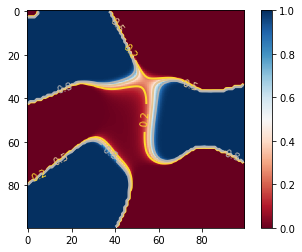

In [18]:
summ()

Now let's try to solve the problem using Kernels

In [19]:
Sigma = 10
def norm(x):
    return x[0]**2+x[1]**2
def K(u, x):
    return np.exp(-norm(u-x)*Sigma)
def prod(x, X, Y):
    vec = [(-1 if yd == 0 else 1)*K(xd, x) for (xd,yd) in zip(X,Y)]
    return np.sum(vec)
def h(x, X, Y):
    return sig(prod(x, X, Y))

In [20]:
def pred(data, dummy):
    return [h(x,X,Y) for x in data];

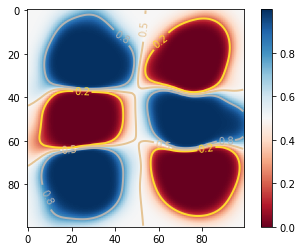

In [21]:
summ()